In [1]:
%matplotlib inline
from Visualization import give_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
sns.set()
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_all = give_data(['Source', 'Month', 'Brand', 'Model', 'SALES THS.UAH'])# читаємо та обробляємо
data_all = data_all[data_all['Source'] == 'Traditional Sales']
data_all = data_all[data_all['Brand'] == 'SAMSUNG']

In [3]:
data = data_all[data_all['Model'] == 'RB37J5000SA/UA']
data.head()

,Source,Month,Brand,Model,SALES THS.UAH
3,Traditional Sales,2018-01-01,SAMSUNG,RB37J5000SA/UA,8362.847073
1709,Traditional Sales,2018-02-01,SAMSUNG,RB37J5000SA/UA,8093.132480
3290,Traditional Sales,2018-03-01,SAMSUNG,RB37J5000SA/UA,10372.118590
4918,Traditional Sales,2018-04-01,SAMSUNG,RB37J5000SA/UA,9493.138200
6592,Traditional Sales,2018-05-01,SAMSUNG,RB37J5000SA/UA,12460.659700


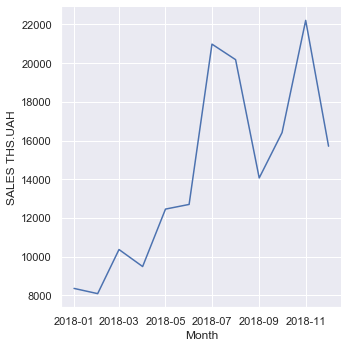

In [4]:
sns.relplot(x='Month', y='SALES THS.UAH',kind='line', data=data)# візуалізація

In [5]:
otg = data[['Month', 'SALES THS.UAH']]# обробка
otg = otg.set_index('Month')
otg.index = otg.index.to_period(freq='M')
itog = otg.describe()
itog

,SALES THS.UAH
count,12.000000
mean,14253.874673
std,4922.146484
min,8093.132480
25%,10152.373493
50%,13385.282851
75%,17355.349152
max,22208.968471


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1459BD48>]],
      dtype=object)

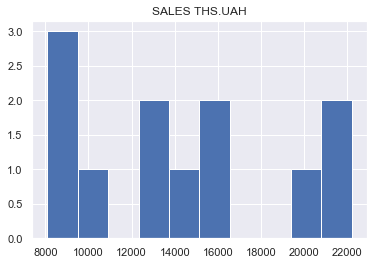

In [6]:
otg.hist()

In [7]:
res = []#пошук параметру для SimpleExpSmoothing
for i in range(1000):
    fit3 = SimpleExpSmoothing(otg).fit(smoothing_level=i/1000,optimized=False)
    res += [[i/1000, ((otg['SALES THS.UAH']- fit3.fittedvalues)**2).sum()]]
res = sorted(res, key=lambda x: x[1])
print(res[0])

[0.585, 178862697.8767758]


In [8]:
res = []#пошук параметру для Holt
for i in range(100):
    for j in range(100):
        fit3 = Holt(otg).fit(smoothing_level=0.5804, smoothing_slope=i/100)
        res += [[[j/100, i/100], fit3.aic]]
res = sorted(res, key=lambda x: x[1])
print(res[0])

[[0.0, 0.0], 204.5142956319308]


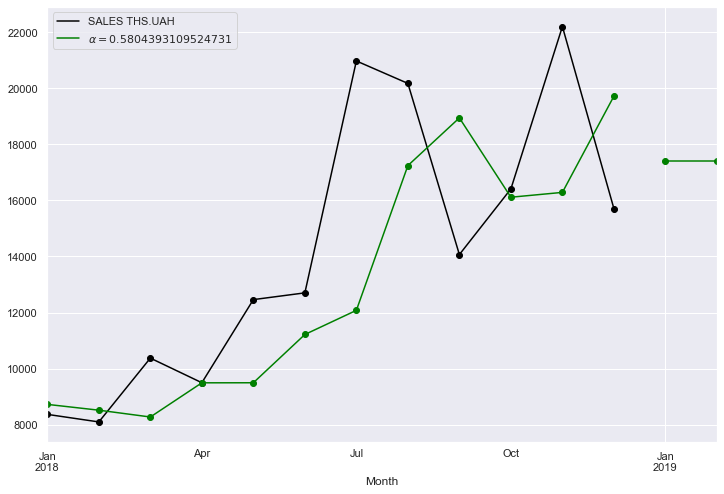

In [9]:
#прогноз за допомогою SimpleExpSmoothing
fit1 = SimpleExpSmoothing(otg).fit()
fcast1 = fit1.forecast(2).rename(r'$\alpha=%s$'%fit1.model.params['smoothing_level'])
ax = otg.plot(marker='o', color='black', figsize=(12,8))
fcast1.plot(marker='o', ax=ax, color='green', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='green')
plt.show()

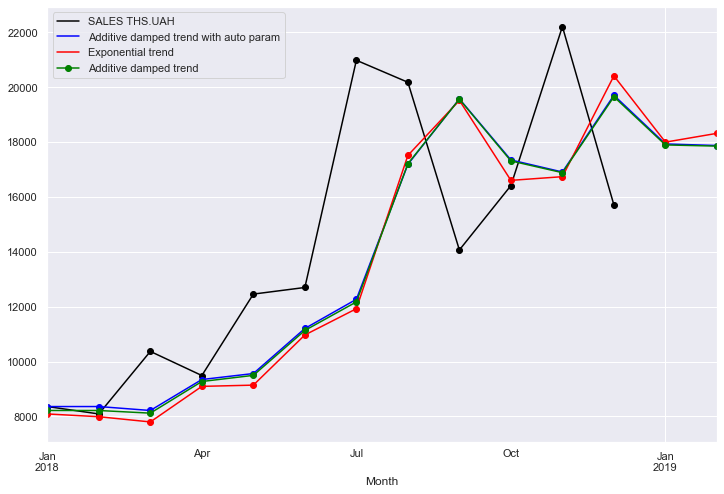

In [10]:
fit1 = Holt(otg, damped=True).fit()
fcast1 = fit1.forecast(2)
fcast1 = pd.concat([fit1.fittedvalues, fcast1]).rename("Additive damped trend with auto param")
fit2 = Holt(otg, exponential=True).fit(smoothing_level=0.5804, smoothing_slope=0.053, optimized=False)
fcast2 = fit2.forecast(2)
fcast2 = pd.concat([fit2.fittedvalues, fcast2]).rename("Exponential trend")
fit3 = Holt(otg, damped=True, exponential=True).fit()
fcast3 = fit3.forecast(2)
fcast3 = pd.concat([fit3.fittedvalues, fcast3]).rename("Additive damped trend")
ax = otg.plot(marker='o', color='black', figsize=(12,8))
fcast1.plot(color='blue', marker="o", legend=True)
fcast2.plot(color='red', marker="o", legend=True)
fcast3.plot(color='green', marker="o", legend=True)
plt.show()

In [11]:
fit1 = SimpleExpSmoothing(otg).fit(smoothing_level=0.5804)
fit2 = Holt(otg).fit(smoothing_level=0.5804, smoothing_slope=0.053)
fit3 = Holt(otg,exponential=True).fit(smoothing_level=0.5804)
fit4 = Holt(otg,damped=True).fit()
fit5 = Holt(otg,exponential=True,damped=True).fit()
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'initial_level', 'initial_slope']
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$l_0$","$b_0$","SSE"] ,columns=['SES', "Holt's","Exponential", "Additive", "Multiplicative"])
results["SES"] =            [fit1.params[p] for p in params] + [fit1.sse]
results["Holt's"] =         [fit2.params[p] for p in params] + [fit2.sse]
results["Exponential"] =    [fit3.params[p] for p in params] + [fit3.sse]
results["Additive"] =       [fit4.params[p] for p in params] + [fit4.sse]
results["Multiplicative"] = [fit5.params[p] for p in params] + [fit5.sse]
results

,SES,Holt's,Exponential,Additive,Multiplicative
$\alpha$,5.804000e-01,5.804000e-01,5.804000e-01,4.210526e-01,4.210526e-01
$\beta$,NaN,5.300000e-02,0.000000e+00,4.210526e-01,4.210526e-01
$\phi$,NaN,NaN,NaN,6.315789e-01,5.263158e-01
$l_0$,8.720771e+03,7.109169e+03,8.362847e+03,8.362847e+03,8.362847e+03
$b_0$,NaN,9.334661e+02,1.043452e+00,0.000000e+00,1.867498e+00
SSE,1.787138e+08,1.615259e+08,1.675942e+08,1.753840e+08,1.776313e+08


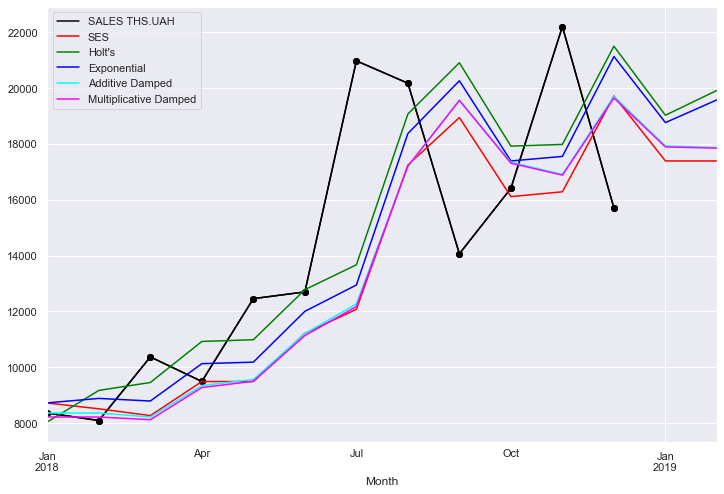

In [12]:
fit1 = SimpleExpSmoothing(otg).fit(smoothing_level=0.5804)
fcast1 = fit1.forecast(2)
fcast1 = pd.concat([fit1.fittedvalues, fcast1]).rename("SES")
fit2 = Holt(otg).fit(smoothing_level=0.5804, smoothing_slope=0.053)
fcast2 = fit2.forecast(2)
fcast2 = pd.concat([fit2.fittedvalues, fcast2]).rename("Holt's")
fit3 = Holt(otg, exponential=True).fit(smoothing_level=0.5804)
fcast3 = fit3.forecast(2)
fcast3 = pd.concat([fit3.fittedvalues, fcast3]).rename("Exponential")
fit4 = Holt(otg, damped=True).fit()
fcast4 = fit4.forecast(2)
fcast4 = pd.concat([fit4.fittedvalues, fcast4]).rename("Additive Damped")
fit5 = Holt(otg, exponential=True, damped=True).fit()
fcast5 = fit5.forecast(2)
fcast5 = pd.concat([fit5.fittedvalues, fcast5]).rename("Multiplicative Damped")
ax = otg.plot(color="black", marker="o", figsize=(12,8))
otg.plot(ax=ax, color="black", marker="o", legend=False)
fcast1.plot(ax=ax, color='red', legend=True)
fcast2.plot(ax=ax, color='green', legend=True)
fcast3.plot(ax=ax, color='blue', legend=True)
fcast4.plot(ax=ax, color='cyan', legend=True)
fcast5.plot(ax=ax, color='magenta', legend=True)
plt.show()

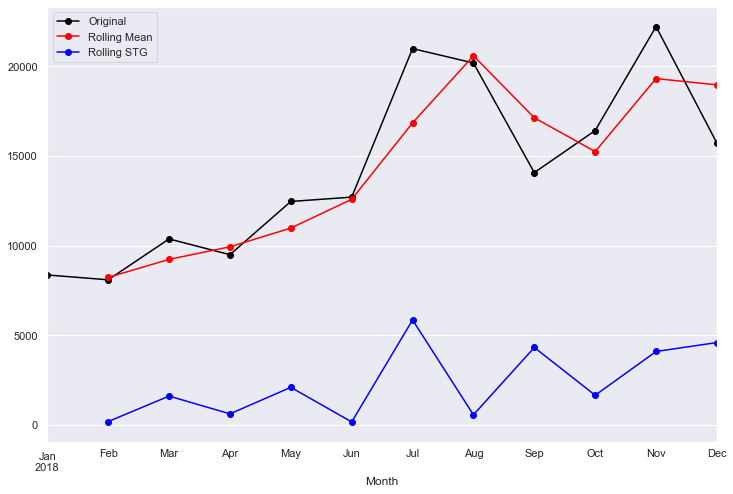

In [13]:
rolmean = otg.rolling(2).mean()
rolstd = otg.rolling(2).std()
ax = otg.plot(color="black", marker="o", figsize=(12,8))
rolmean.plot(ax=ax,color="red", marker="o")
rolstd.plot(ax=ax,color="blue", marker="o")
plt.legend(['Original','Rolling Mean','Rolling STG'])

In [14]:
print('V = ' + str(itog.loc['std'][0]/itog.loc['mean'][0]))

V = 0.3453198935107114


In [15]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']# тест Jarque–Bera
jb_test = sm.stats.stattools.jarque_bera(otg)
a = [np.hstack(jb_test)]
itog = SimpleTable(a, row)
itog

JB,p-value,skew,kurtosis
0.9260143083725912,0.6293881297321238,0.33049314727826057,1.8104094254098924


In [16]:
test = sm.tsa.adfuller(otg['SALES THS.UAH'])#тест Дікі-Фулера
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -1.7808506614069648
p-value: 0.3900093927415634
Critical values: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603}
є одиничні корені, ряд не є стаціонарним


In [17]:
otg1diff = otg.diff(periods=1).dropna()# беремо різниці першого порядку

In [18]:
test = sm.tsa.adfuller(otg1diff['SALES THS.UAH'])
print('adf: ' + str(test[0]))
print('p-value: ' + str(test[1]))
print('Critical values: ' + str(test[4]))
if test[0]> test[4]['5%']: 
    print('є одиничні корені, ряд не є стаціонарним')
else:
    print('одиничних коренів нема, ряд є стаціонарним')

adf: -3.6436590927218813
p-value: 0.004979168875889399
Critical values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124}
одиничних коренів нема, ряд є стаціонарним


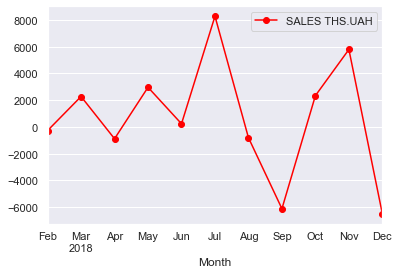

In [19]:
otg1diff.plot(color="red", marker="o")

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

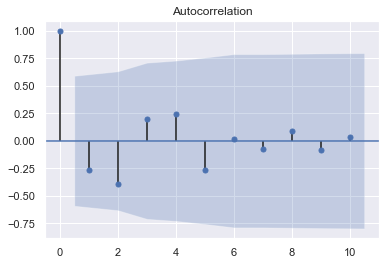

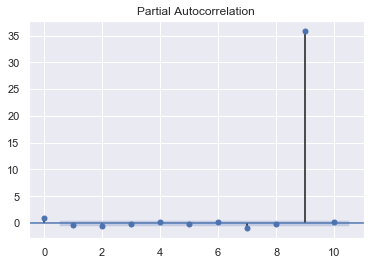

In [20]:
sm.graphics.tsa.plot_acf(otg1diff.values.squeeze()), sm.graphics.tsa.plot_pacf(otg1diff)# ACF & PACF

In [21]:
model = sm.tsa.ARIMA(otg, order=(5,1,0), freq='M').fit(full_output=False)# Побудова моделі
model1 = sm.tsa.ARIMA(otg, order=(2,1,0), freq='M').fit(full_output=False)

In [22]:
def evaluate_models(dataset, p_values, d_values, q_values):# пошук найкращої моделі
    best_score, best_cfg = 1e9, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse =sm.tsa.ARIMA(dataset, order=order, freq='M').fit().aic
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [23]:
evaluate_models(otg, [0,1,2,3,4,5,6,8,9], [1], [0,1,2,3,4,5,6,8,9])

Best ARIMA(5, 1, 0) MSE=216.340


In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.SALES THS.UAH   No. Observations:                   11
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -101.170
Method:                       css-mle   S.D. of innovations       13771607.264
Date:                Wed, 05 Feb 2020   AIC                            216.340
Time:                        13:40:22   BIC                            219.125
Sample:                    02-28-2018   HQIC                           214.584
                         - 12-31-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1249.9168        nan        nan        nan         nan         nan
ar.L1.D.SALES THS.UAH    -0.5033        nan        nan        nan         nan         nan
ar.L2.D.SALES THS.UAH    -0.8528   7.18e-06  -1.19e+05      0.000      -0.853      -0.853
ar.L3.D.SALES THS.UAH    -0.5444   5.42e-06     -1e+05      0.000      -0.544      -0.544
ar.L4.D.SALES THS.UAH    -0.4506   1.58e-06  -2.86e+05      0.000      -0.451      -0.451
ar.L5.D.SALES THS.UAH    -0.7333        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6049           -0.9011j            1.0853           -0.1559
AR.2            0.6049           +0.9011j            1.0853            0.1559
AR.3           -0.3333           -0.9428j            1.0000           -0.3041
AR.4           -0.3333           +0.9428j            1.0000            0.3041
AR.5           -1.1577           -0.0000j            1.1577           -0.5000
-----------------------------------------------------------------------------
"""

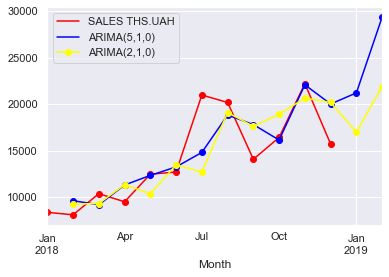

In [25]:
preds =  model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2019-02"), typ='levels').rename('ARIMA(5,1,0)')# прогноз
preds1 =  model1.predict(pd.to_datetime("2018-02"), pd.to_datetime("2019-02"), typ='levels').rename('ARIMA(2,1,0)')
ax = otg.plot(color="red", marker="o",legend=True)
preds.plot(ax=ax,color="blue", marker="o",legend=True)
preds1.plot(ax=ax,color="yellow", marker="o",legend=True)

In [26]:
from sklearn.metrics import r2_score
pred = model.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels')
pred1 = model1.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels')
trn = otg['2018-02':]
r2 = r2_score(trn, pred)
r21 = r2_score(trn, pred1)
print('ARIMA(5,1,0) R^2: %1.2f'%r2)
print('ARIMA(2,1,0) R^2: %1.2f'%r21)

ARIMA(5,1,0) R^2: 0.65
ARIMA(2,1,0) R^2: 0.47


In [27]:
curs = pd.read_csv('curs.csv')
curs['Unnamed: 0'] = pd.to_datetime(curs['Unnamed: 0'])
curs = curs.rename(columns={"Unnamed: 0":"Month"})
curs = curs.set_index('Month')
curs.index = curs.index.to_period(freq='D')

In [28]:
res = {}
for i in range(1,13):
    res[pd.to_datetime('2018-' + str(i))] = curs['2018-' + str(i)].mean()
for i in range(1,3):
    res[pd.to_datetime('2019-' + str(i))] = curs['2019-' + str(i)].mean()

In [29]:
res = pd.DataFrame.from_dict(res, orient='index', columns=['UAH/USD'])
res.index = res.index.to_period(freq='M')

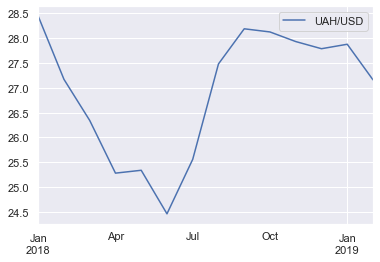

In [30]:
res.plot()

In [31]:
def evaluate_models_x(dataset, p_values, d_values, q_values, exog):# пошук найкращої моделі
    best_score, best_cfg = 1e9, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse =sm.tsa.ARIMA(dataset, order=order, freq='M', exog=exog).fit().aic
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [32]:
evaluate_models_x(otg, [0,1,2,3,4,5,6,7,8,9], [1], [0,1,2,3,4,5,6,7,8,9], res['2018'])

Best ARIMA(3, 1, 0) MSE=209.704


In [33]:
model2 = sm.tsa.ARIMA(otg, order=(3,1,0), exog=res['2018'],freq='M').fit()

In [34]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.SALES THS.UAH   No. Observations:                   11
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -98.852
Method:                       css-mle   S.D. of innovations           2141.767
Date:                Wed, 05 Feb 2020   AIC                            209.704
Time:                        13:40:29   BIC                            212.091
Sample:                    02-28-2018   HQIC                           208.199
                         - 12-31-2018                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2.316e+04   3063.593      7.558      0.000    1.72e+04    2.92e+04
UAH/USD                -836.5168    110.673     -7.558      0.000   -1053.432    -619.602
ar.L1.D.SALES THS.UAH    -1.0592        nan        nan        nan         nan         nan
ar.L2.D.SALES THS.UAH    -1.2364        nan        nan        nan         nan         nan
ar.L3.D.SALES THS.UAH    -0.7395   4.28e-06  -1.73e+05      0.000      -0.739      -0.739
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1599           -0.9871j            1.0000           -0.2756
AR.2           -0.1599           +0.9871j            1.0000            0.2756
AR.3           -1.3523           -0.0000j            1.3523           -0.5000
-----------------------------------------------------------------------------
"""

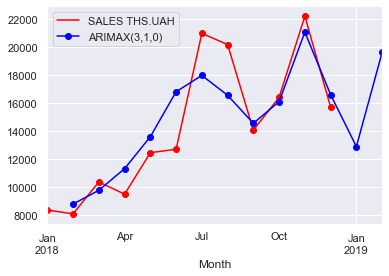

In [35]:
modelplot = model2.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), exog=res['2018'], typ='levels')
preds =  model2.predict(pd.to_datetime("2019-01"), pd.to_datetime("2019-02"), exog=res['2019'], typ='levels')# прогноз
X_data = pd.concat([modelplot, preds]).rename('ARIMAX(3,1,0)')
ax = otg.plot(color="red", marker="o",legend=True)
X_data.plot(ax=ax,color="blue", marker="o",legend=True)

In [36]:
from sklearn.metrics import r2_score
pred = model2.predict(pd.to_datetime("2018-02"), pd.to_datetime("2018-12"), typ='levels', exog=res['2018'])
trn = otg['2018-02':]
r2 = r2_score(trn, pred)
print('ARIMAX(3,1,0) R^2: %1.2f'%r2)

ARIMAX(3,1,0) R^2: 0.79
